# Home Price Prediction Model

In [77]:
import pandas as pd
import numpy as numpy
import seaborn as sns
from prophet import Prophet
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

### Goal: Create a forecast of home prices using machine learning algorythms.
- V1 will be done using [Prophet](https://pypi.org/project/prophet/)

## Data


### Recessions

[Real-time Sahm Rule Recession Indicator](https://fred.stlouisfed.org/series/SAHMREALTIME)

Sahm Recession Indicator signals the start of a recession when the three-month moving average of the national unemployment rate (U3) rises by 0.50 percentage points or more relative to the minimum of the three-month averages from the previous 12 months.

In [3]:
df_sahm = pd.read_csv('SAHMREALTIME.csv')
df_sahm.head()


,DATE,SAHMREALTIME
0,1959-12-01,0.77
1,1960-01-01,0.50
2,1960-02-01,0.13
3,1960-03-01,0.10
4,1960-04-01,0.03


In [4]:
df_sahm.tail()

,DATE,SAHMREALTIME
764,2023-08-01,0.13
765,2023-09-01,0.20
766,2023-10-01,0.33
767,2023-11-01,0.30
768,2023-12-01,0.23


In [5]:
df_sahm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          769 non-null    object 
 1   SAHMREALTIME  769 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.1+ KB


### Interest Rates

[Federal Funds Effective Rate](https://fred.stlouisfed.org/series/FEDFUNDS)

The federal funds rate is the interest rate at which depository institutions trade federal funds (balances held at Federal Reserve Banks) with each other overnight. The federal funds rate is the central interest rate in the U.S. financial market. It influences other interest rates such as the prime rate, which is the rate banks charge their customers with higher credit ratings. Additionally, the federal funds rate indirectly influences longer- term interest rates such as mortgages, loans, and savings, all of which are very important to consumer wealth and confidence. 

In [6]:
df_fed = pd.read_csv('FEDFUNDS.csv')
df_fed.head()


,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


In [7]:
df_fed.tail()

,DATE,FEDFUNDS
829,2023-08-01,5.33
830,2023-09-01,5.33
831,2023-10-01,5.33
832,2023-11-01,5.33
833,2023-12-01,5.33


In [8]:
df_fed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATE      834 non-null    object 
 1   FEDFUNDS  834 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.2+ KB


### Housing Prices

[S&P CoreLogic Case-Shiller U.S. National Home Price Index](https://fred.stlouisfed.org/series/CSUSHPINSA)
The S&P CoreLogic Case-Shiller Home Price Indices are calculated monthly using a three-month moving average. Index levels are published with a two-month lag and are released at 9 am EST on the last Tuesday of every month. Index performance is based on non-seasonally adjusted data.


In [9]:
df_csus = pd.read_csv('CSUSHPINSA.csv')
df_csus.head()

,DATE,CSUSHPINSA
0,1987-01-01,63.735
1,1987-02-01,64.134
2,1987-03-01,64.470
3,1987-04-01,64.973
4,1987-05-01,65.547


In [10]:
df_csus.tail()

,DATE,CSUSHPINSA
437,2023-06-01,308.285
438,2023-07-01,310.146
439,2023-08-01,311.519
440,2023-09-01,312.417
441,2023-10-01,312.953


In [11]:
# rename column to Home Price Index

df_csus = df_csus.rename(columns={
                    'CSUSHPINSA' : 'Home Price Index'
})

In [12]:
df_csus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              442 non-null    object 
 1   Home Price Index  442 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.0+ KB


## Employed full time: Median usual weekly real earnings: Wage and salary workers: 16 years and over

Data measure usual weekly earnings of wage and salary workers. Wage and salary workers are workers who receive wages, salaries, commissions, tips, payment in kind, or piece rates. The group includes employees in both the private and public sectors but, for the purposes of the earnings series, it excludes all self-employed persons, both those with incorporated businesses and those with unincorporated businesses.

In [13]:
df_wage = pd.read_csv('LES1252881600Q.csv')
df_wage.head()

,DATE,LES1252881600Q
0,1979-01-01,335
1,1979-04-01,335
2,1979-07-01,330
3,1979-10-01,326
4,1980-01-01,321


In [14]:
df_wage.tail()

,DATE,LES1252881600Q
175,2022-10-01,363
176,2023-01-01,363
177,2023-04-01,365
178,2023-07-01,366
179,2023-10-01,371


In [15]:
df_wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DATE            180 non-null    object
 1   LES1252881600Q  180 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ KB


#### Observations

- Each data set contains a different number of rows
- They all have a different start date
- fed & sahm have same end dates; csus has a different end date
- They all are monthly
- There are no null values
- Employment data is quarterly while other datasets are monthly

#### Recommendations

- Trim the data sets so they all have matching start and end dates in order to concatenate them using date as the common value
- Create a quarterly column to be able to join datasets

## Data Wrangling

- Trim all data sets to common start date of 1987-01-01 and end date of 2023-10-01
- Create quarterly column
- Join data on quarterly column


### Extract Month from Wage Data & Define Quarterly column

In [16]:
df_wage['Year']= df_wage['DATE'].str[0:4]
df_wage['Year']

0      1979
1      1979
2      1979
3      1979
4      1980
       ... 
175    2022
176    2023
177    2023
178    2023
179    2023
Name: Year, Length: 180, dtype: object

In [17]:
df_wage['Month']= df_wage['DATE'].str[5:7]
df_wage['Month']

0      01
1      04
2      07
3      10
4      01
       ..
175    10
176    01
177    04
178    07
179    10
Name: Month, Length: 180, dtype: object

In [18]:
df_wage['Quarter'] = df_wage['Month'].map({'01': 1, '04': 2, '07': 3, '10': 4}).astype(int)
df_wage


,DATE,LES1252881600Q,Year,Month,Quarter
0,1979-01-01,335,1979,01,1
1,1979-04-01,335,1979,04,2
2,1979-07-01,330,1979,07,3
3,1979-10-01,326,1979,10,4
4,1980-01-01,321,1980,01,1
...,...,...,...,...,...
175,2022-10-01,363,2022,10,4
176,2023-01-01,363,2023,01,1
177,2023-04-01,365,2023,04,2
178,2023-07-01,366,2023,07,3


In [19]:
# rename column to wage

df_wage = df_wage.rename(columns={
                    'LES1252881600Q' : 'Wages'
})
df_wage

,DATE,Wages,Year,Month,Quarter
0,1979-01-01,335,1979,01,1
1,1979-04-01,335,1979,04,2
2,1979-07-01,330,1979,07,3
3,1979-10-01,326,1979,10,4
4,1980-01-01,321,1980,01,1
...,...,...,...,...,...
175,2022-10-01,363,2022,10,4
176,2023-01-01,363,2023,01,1
177,2023-04-01,365,2023,04,2
178,2023-07-01,366,2023,07,3


In [20]:
# Trim wage data to match other datasets

df_wage[df_wage['DATE']=='1987-01-01'].index

Index([32], dtype='int64')

In [21]:
df_wage[df_wage['DATE']=='2023-10-01'].index

Index([179], dtype='int64')

In [22]:
df_wage_trim = df_wage.loc[32:179]

df_wage_trim

,DATE,Wages,Year,Month,Quarter
32,1987-01-01,328,1987,01,1
33,1987-04-01,328,1987,04,2
34,1987-07-01,330,1987,07,3
35,1987-10-01,328,1987,10,4
36,1988-01-01,329,1988,01,1
...,...,...,...,...,...
175,2022-10-01,363,2022,10,4
176,2023-01-01,363,2023,01,1
177,2023-04-01,365,2023,04,2
178,2023-07-01,366,2023,07,3


### Trim sahm

In [23]:
display(df_sahm.iloc[325])

DATE            1987-01-01
SAHMREALTIME         -0.07
Name: 325, dtype: object

In [24]:
df_sahm[df_sahm['DATE']=='1987-01-01'].index

Index([325], dtype='int64')

In [25]:
display(df_sahm.iloc[766])

DATE            2023-10-01
SAHMREALTIME          0.33
Name: 766, dtype: object

In [26]:
df_sahm_trim = df_sahm.loc[325:766]

df_sahm_trim

,DATE,SAHMREALTIME
325,1987-01-01,-0.07
326,1987-02-01,-0.07
327,1987-03-01,-0.03
328,1987-04-01,-0.13
329,1987-05-01,-0.13
...,...,...
762,2023-06-01,0.07
763,2023-07-01,0.10
764,2023-08-01,0.13
765,2023-09-01,0.20


In [27]:
df_sahm_trim.columns

Index(['DATE', 'SAHMREALTIME'], dtype='object')

In [28]:
# rename column to Recessions

df_sahm_trim = df_sahm_trim.rename(columns={
                    'SAHMREALTIME' : 'Recession Indicator'
})
df_sahm_trim

,DATE,Recession Indicator
325,1987-01-01,-0.07
326,1987-02-01,-0.07
327,1987-03-01,-0.03
328,1987-04-01,-0.13
329,1987-05-01,-0.13
...,...,...
762,2023-06-01,0.07
763,2023-07-01,0.10
764,2023-08-01,0.13
765,2023-09-01,0.20


In [29]:
df_sahm_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 325 to 766
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE                 442 non-null    object 
 1   Recession Indicator  442 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.0+ KB


### Trim Fed



In [30]:
# find location of start date
display(df_fed.iloc[390])


DATE        1987-01-01
FEDFUNDS          6.43
Name: 390, dtype: object

In [31]:
display(df_fed.iloc[390])

DATE        1987-01-01
FEDFUNDS          6.43
Name: 390, dtype: object

In [32]:
df_fed_trim = df_fed.loc[390:831]

df_fed_trim

,DATE,FEDFUNDS
390,1987-01-01,6.43
391,1987-02-01,6.10
392,1987-03-01,6.13
393,1987-04-01,6.37
394,1987-05-01,6.85
...,...,...
827,2023-06-01,5.08
828,2023-07-01,5.12
829,2023-08-01,5.33
830,2023-09-01,5.33


In [33]:
# rename column to Interest Rate

df_fed_trim = df_fed_trim.rename(columns={
                    'FEDFUNDS' : 'Interest Rate'
})

In [34]:
df_fed_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 390 to 831
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DATE           442 non-null    object 
 1   Interest Rate  442 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.0+ KB


### Join Data

In [35]:
combined_data_01 = pd.merge(df_csus, df_fed_trim, how='left', on='DATE') 
combined_data_01.head()

,DATE,Home Price Index,Interest Rate
0,1987-01-01,63.735,6.43
1,1987-02-01,64.134,6.10
2,1987-03-01,64.470,6.13
3,1987-04-01,64.973,6.37
4,1987-05-01,65.547,6.85


In [36]:
combined_data_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              442 non-null    object 
 1   Home Price Index  442 non-null    float64
 2   Interest Rate     442 non-null    float64
dtypes: float64(2), object(1)
memory usage: 10.5+ KB


In [37]:
combined_data_02 = pd.merge(combined_data_01, df_sahm_trim, how='inner', on='DATE') 
combined_data_02.head()

# left join on quarter column

,DATE,Home Price Index,Interest Rate,Recession Indicator
0,1987-01-01,63.735,6.43,-0.07
1,1987-02-01,64.134,6.10,-0.07
2,1987-03-01,64.470,6.13,-0.03
3,1987-04-01,64.973,6.37,-0.13
4,1987-05-01,65.547,6.85,-0.13


<Axes: >

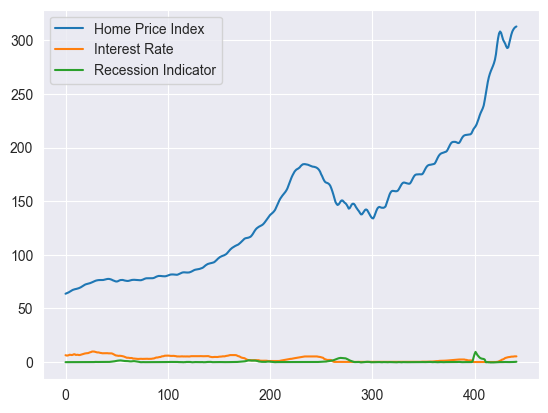

In [38]:
# visualize combined data

combined_data_02.plot(kind='line')

### Feature Engineering



In [39]:
combined_data_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE                 442 non-null    object 
 1   Home Price Index     442 non-null    float64
 2   Interest Rate        442 non-null    float64
 3   Recession Indicator  442 non-null    float64
dtypes: float64(3), object(1)
memory usage: 13.9+ KB


In [40]:
# create seperate columns for month & year

combined_data_02['Year']= combined_data_02['DATE'].str[0:4]
combined_data_02['Year']

0      1987
1      1987
2      1987
3      1987
4      1987
       ... 
437    2023
438    2023
439    2023
440    2023
441    2023
Name: Year, Length: 442, dtype: object

In [41]:
combined_data_02['Month']= combined_data_02['DATE'].str[5:7]
combined_data_02['Month']

0      01
1      02
2      03
3      04
4      05
       ..
437    06
438    07
439    08
440    09
441    10
Name: Month, Length: 442, dtype: object

In [42]:
combined_data_02

,DATE,Home Price Index,Interest Rate,Recession Indicator,Year,Month
0,1987-01-01,63.735,6.43,-0.07,1987,01
1,1987-02-01,64.134,6.10,-0.07,1987,02
2,1987-03-01,64.470,6.13,-0.03,1987,03
3,1987-04-01,64.973,6.37,-0.13,1987,04
4,1987-05-01,65.547,6.85,-0.13,1987,05
...,...,...,...,...,...,...
437,2023-06-01,308.285,5.08,0.07,2023,06
438,2023-07-01,310.146,5.12,0.10,2023,07
439,2023-08-01,311.519,5.33,0.13,2023,08
440,2023-09-01,312.417,5.33,0.20,2023,09


In [43]:
combined_data_02['Quarter'] = combined_data_02['Month'].map({'01': 1, '02': 1, '03': 1, '04': 2, '05': 2, '06': 2, '07': 3, '08': 3, '09': 3, '10': 4, '11': 4, '12': 4}).astype(int)
combined_data_02

,DATE,Home Price Index,Interest Rate,Recession Indicator,Year,Month,Quarter
0,1987-01-01,63.735,6.43,-0.07,1987,01,1
1,1987-02-01,64.134,6.10,-0.07,1987,02,1
2,1987-03-01,64.470,6.13,-0.03,1987,03,1
3,1987-04-01,64.973,6.37,-0.13,1987,04,2
4,1987-05-01,65.547,6.85,-0.13,1987,05,2
...,...,...,...,...,...,...,...
437,2023-06-01,308.285,5.08,0.07,2023,06,2
438,2023-07-01,310.146,5.12,0.10,2023,07,3
439,2023-08-01,311.519,5.33,0.13,2023,08,3
440,2023-09-01,312.417,5.33,0.20,2023,09,3


In [44]:
df_wage_trim

,DATE,Wages,Year,Month,Quarter
32,1987-01-01,328,1987,01,1
33,1987-04-01,328,1987,04,2
34,1987-07-01,330,1987,07,3
35,1987-10-01,328,1987,10,4
36,1988-01-01,329,1988,01,1
...,...,...,...,...,...
175,2022-10-01,363,2022,10,4
176,2023-01-01,363,2023,01,1
177,2023-04-01,365,2023,04,2
178,2023-07-01,366,2023,07,3


In [45]:
df_wage.loc[32:40]

,DATE,Wages,Year,Month,Quarter
32,1987-01-01,328,1987,01,1
33,1987-04-01,328,1987,04,2
34,1987-07-01,330,1987,07,3
35,1987-10-01,328,1987,10,4
36,1988-01-01,329,1988,01,1
37,1988-04-01,325,1988,04,2
38,1988-07-01,325,1988,07,3
39,1988-10-01,324,1988,10,4
40,1989-01-01,323,1989,01,1


In [46]:
combined_data_03 = pd.merge(combined_data_02, df_wage_trim, how='left', on=['Quarter', 'Year']) 
combined_data_03.head()

,DATE_x,Home Price Index,Interest Rate,Recession Indicator,Year,Month_x,Quarter,DATE_y,Wages,Month_y
0,1987-01-01,63.735,6.43,-0.07,1987,01,1,1987-01-01,328,01
1,1987-02-01,64.134,6.10,-0.07,1987,02,1,1987-01-01,328,01
2,1987-03-01,64.470,6.13,-0.03,1987,03,1,1987-01-01,328,01
3,1987-04-01,64.973,6.37,-0.13,1987,04,2,1987-04-01,328,04
4,1987-05-01,65.547,6.85,-0.13,1987,05,2,1987-04-01,328,04


In [47]:
combined_data_03 = combined_data_03.drop(['DATE_y', 'Month_y'], axis=1)

In [48]:
combined_data_03

,DATE_x,Home Price Index,Interest Rate,Recession Indicator,Year,Month_x,Quarter,Wages
0,1987-01-01,63.735,6.43,-0.07,1987,01,1,328
1,1987-02-01,64.134,6.10,-0.07,1987,02,1,328
2,1987-03-01,64.470,6.13,-0.03,1987,03,1,328
3,1987-04-01,64.973,6.37,-0.13,1987,04,2,328
4,1987-05-01,65.547,6.85,-0.13,1987,05,2,328
...,...,...,...,...,...,...,...,...
437,2023-06-01,308.285,5.08,0.07,2023,06,2,365
438,2023-07-01,310.146,5.12,0.10,2023,07,3,366
439,2023-08-01,311.519,5.33,0.13,2023,08,3,366
440,2023-09-01,312.417,5.33,0.20,2023,09,3,366


In [67]:
year_quarter = combined_data_03[['Year', 'Quarter']]
year_quarter

,Year,Quarter
0,1987,1
1,1987,1
2,1987,1
3,1987,2
4,1987,2
...,...,...
437,2023,2
438,2023,3
439,2023,3
440,2023,3


In [72]:
year = combined_data_03['Year']
year

0      1987
1      1987
2      1987
3      1987
4      1987
       ... 
437    2023
438    2023
439    2023
440    2023
441    2023
Name: Year, Length: 442, dtype: object

<Axes: xlabel='DATE_x'>

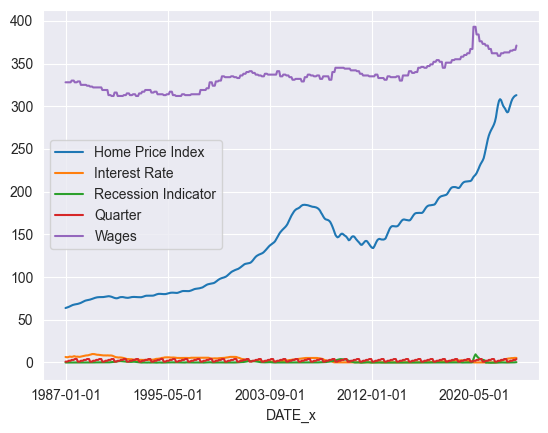

In [49]:
combined_data_03.plot(kind='line', x='DATE_x')

In [55]:
SS = StandardScaler()
SS_scaled = SS.fit_transform(combined_data_03[['Home Price Index', 'Interest Rate', 'Recession Indicator', 'Wages']])
SS_scaled

array([[-1.27455029,  1.21839689, -0.41240907, -0.44363008],
       [-1.26807822,  1.09496972, -0.41240907, -0.44363008],
       [-1.26262807,  1.10619038, -0.37547754, -0.44363008],
       ...,
       [ 2.74468142,  0.806973  , -0.22775141,  1.83851719],
       [ 2.75924761,  0.806973  , -0.16312123,  1.83851719],
       [ 2.76794191,  0.806973  , -0.04309375,  2.13879972]])

In [58]:
scaled_features = pd.DataFrame(SS_scaled)
scaled_features 

,0,1,2,3
0,-1.274550,1.218397,-0.412409,-0.443630
1,-1.268078,1.094970,-0.412409,-0.443630
2,-1.262628,1.106190,-0.375478,-0.443630
3,-1.254469,1.195956,-0.467806,-0.443630
4,-1.245158,1.375486,-0.467806,-0.443630
...,...,...,...,...
437,2.692224,0.713468,-0.283149,1.778461
438,2.722410,0.728428,-0.255450,1.838517
439,2.744681,0.806973,-0.227751,1.838517
440,2.759248,0.806973,-0.163121,1.838517


In [63]:


scaled_features = scaled_features.rename(columns={
                    0 : 'Home Price Index',
                    1 : 'Interest Rate',
                    2 : 'Recession Indicator',
                    3 : 'Wages'
})

In [64]:
scaled_features

,Home Price Index,Interest Rate,Recession Indicator,Wages
0,-1.274550,1.218397,-0.412409,-0.443630
1,-1.268078,1.094970,-0.412409,-0.443630
2,-1.262628,1.106190,-0.375478,-0.443630
3,-1.254469,1.195956,-0.467806,-0.443630
4,-1.245158,1.375486,-0.467806,-0.443630
...,...,...,...,...
437,2.692224,0.713468,-0.283149,1.778461
438,2.722410,0.728428,-0.255450,1.838517
439,2.744681,0.806973,-0.227751,1.838517
440,2.759248,0.806973,-0.163121,1.838517


In [68]:
scaled_featues_mo_ye = scaled_features.join(year_quarter)
scaled_featues_mo_ye.head()

,Home Price Index,Interest Rate,Recession Indicator,Wages,Year,Quarter
0,-1.274550,1.218397,-0.412409,-0.44363,1987,1
1,-1.268078,1.094970,-0.412409,-0.44363,1987,1
2,-1.262628,1.106190,-0.375478,-0.44363,1987,1
3,-1.254469,1.195956,-0.467806,-0.44363,1987,2
4,-1.245158,1.375486,-0.467806,-0.44363,1987,2


In [73]:
scaled_featues_ye = scaled_features.join(year)
scaled_featues_ye.head()

,Home Price Index,Interest Rate,Recession Indicator,Wages,Year
0,-1.274550,1.218397,-0.412409,-0.44363,1987
1,-1.268078,1.094970,-0.412409,-0.44363,1987
2,-1.262628,1.106190,-0.375478,-0.44363,1987
3,-1.254469,1.195956,-0.467806,-0.44363,1987
4,-1.245158,1.375486,-0.467806,-0.44363,1987


<Axes: xlabel='Year'>

<Figure size 1200x600 with 0 Axes>

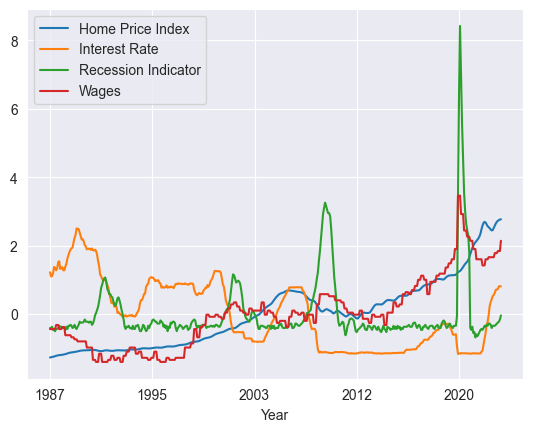

In [78]:
fig = plt.figure(figsize=(12,6))
scaled_featues_ye.plot(kind='line', x='Year')

## Run Prophet algorythm to predict home prices based on date and price

In [45]:
# Rename columns to ds & y for Prophet
combined_data_02 = combined_data_02.rename(columns={'DATE': 'ds', 'Home Price Index': 'y'})
combined_data_02

,ds,y,Interest Rate,Recession Indicator,Year,Month,Quarter
0,1987-01-01,63.735,6.43,-0.07,1987,01,1
1,1987-02-01,64.134,6.10,-0.07,1987,02,1
2,1987-03-01,64.470,6.13,-0.03,1987,03,1
3,1987-04-01,64.973,6.37,-0.13,1987,04,2
4,1987-05-01,65.547,6.85,-0.13,1987,05,2
...,...,...,...,...,...,...,...
437,2023-06-01,308.285,5.08,0.07,2023,06,2
438,2023-07-01,310.146,5.12,0.10,2023,07,3
439,2023-08-01,311.519,5.33,0.13,2023,08,3
440,2023-09-01,312.417,5.33,0.20,2023,09,3


In [46]:
prophet_m = Prophet()
prophet_m.fit(combined_data_02)

14:56:58 - cmdstanpy - INFO - Chain [1] start processing
14:56:58 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
future = prophet_m.make_future_dataframe(periods=730)
future.tail()

,ds
1167,2025-09-26
1168,2025-09-27
1169,2025-09-28
1170,2025-09-29
1171,2025-09-30


In [48]:
forecast = prophet_m.predict(future)
forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_df.tail()


,ds,yhat,yhat_lower,yhat_upper
1167,2025-09-26,343.329688,332.523015,353.852683
1168,2025-09-27,342.556892,330.915771,352.748545
1169,2025-09-28,341.694707,331.145777,352.173647
1170,2025-09-29,340.762755,330.343664,351.510766
1171,2025-09-30,339.782574,328.692087,350.183737


<Axes: xlabel='ds'>

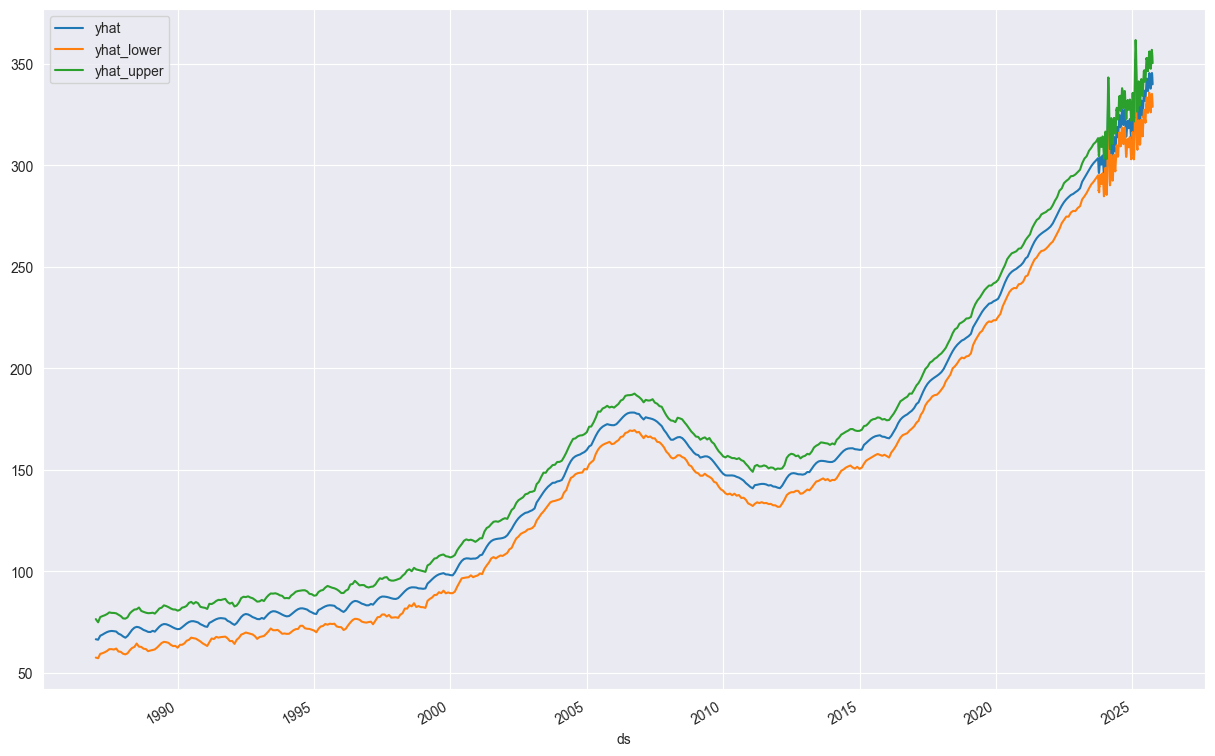

In [49]:
# Visualize the forecast

forecast_df.plot(kind='line', x='ds', y=['yhat', 'yhat_lower', 'yhat_upper'], figsize=(15,10))

### Observation

- The model is predicting conintued growth of home prices in the next 365 days
- It would be helpful to work witha model that considers other factors like interest rates and unemployment rates.

## Linear Regression

- Perform linear regression to analyse coeficients of data elements like recessions and interest rates to determin relationship to home values
- Build functions to plot coefficient releationships

In [110]:
combined_data_03.columns

Index(['DATE_x', 'Home Price Index', 'Interest Rate', 'Recession Indicator',
       'Year', 'Month_x', 'Quarter', 'Wages'],
      dtype='object')

In [111]:
combined_data_03.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_x               442 non-null    object 
 1   Home Price Index     442 non-null    float64
 2   Interest Rate        442 non-null    float64
 3   Recession Indicator  442 non-null    float64
 4   Year                 442 non-null    object 
 5   Month_x              442 non-null    object 
 6   Quarter              442 non-null    int64  
 7   Wages                442 non-null    int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 27.8+ KB


In [112]:
# define features (X) and target (y)

X = combined_data_03.drop(columns=['DATE_x', 'Home Price Index', 'Year', 'Month_x', 'Quarter'])
y = combined_data_03['Home Price Index']

In [113]:
X_constant = sm.add_constant(X)

OLS_model = sm.OLS(y, X_constant).fit()

In [114]:
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Home Price Index   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     611.3
Date:                Wed, 24 Jan 2024   Prob (F-statistic):          4.13e-156
Time:                        15:31:50   Log-Likelihood:                -2085.1
No. Observations:                 442   AIC:                             4178.
Df Residuals:                     438   BIC:                             4195.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -973.4384     33.925    -28.694      0.000   -1040.115    -906.762
Interest Rate          -1.8578      0.590     -3.151      0.002      -3.017      -0.699
Recession Indicator   -13.4922      1.279    -10.547      0.000     -16.006     -10.978
Wages                   3.3595      0.098     34.156      0.000       3.166       3.553
==============================================================================
Omnibus:                       12.985   Durbin-Watson:                   0.060
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.515
Skew:                           0.428   Prob(JB):                      0.00116
Kurtosis:                       3.045   Cond. No.                     8.81e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# apply the lasso, ridge, regression (gridsearchCV)

In [115]:
combined_data_03[combined_data_03['DATE_x']=='2010-01-01'].index

Index([276], dtype='int64')

In [ ]:
combined_data_03 = 

In [117]:
# Split data for training & testing; use data pre-2010 as training & post 2010 as test

X_train = X.loc[0:277]
X_test = X.loc[277:]

y_train = y.loc[0:277]
y_test = y.loc[277:]

In [118]:
X_train

,Interest Rate,Recession Indicator,Wages
0,6.43,-0.07,328
1,6.10,-0.07,328
2,6.13,-0.03,328
3,6.37,-0.13,328
4,6.85,-0.13,328
...,...,...,...
273,0.12,3.57,344
274,0.12,3.47,344
275,0.12,3.07,344
276,0.11,2.57,344


In [119]:
X_test

,Interest Rate,Recession Indicator,Wages
277,0.13,2.03,344
278,0.16,1.53,344
279,0.20,1.20,342
280,0.20,0.80,342
281,0.18,0.43,342
...,...,...,...
437,5.08,0.07,365
438,5.12,0.10,366
439,5.33,0.13,366
440,5.33,0.20,366


In [120]:
y_train

0       63.735
1       64.134
2       64.470
3       64.973
4       65.547
        ...   
273    148.584
274    147.939
275    146.664
276    145.003
277    143.054
Name: Home Price Index, Length: 278, dtype: float64

In [121]:
y_test

277    143.054
278    143.596
279    145.404
280    147.040
281    147.705
        ...   
437    308.285
438    310.146
439    311.519
440    312.417
441    312.953
Name: Home Price Index, Length: 165, dtype: float64

In [124]:
# define model parameters

models_params = [
    {'name': 'LinearRegression', 'model' : LinearRegression()},
    {'name': 'Ridge', 'model':Ridge(), 'params': {'alpha':[0.1,1,10,100]}},
    {'name': 'Lasso', 'model':Lasso(), 'params': {'alpha':[0.1,1,10,100]}}
]

In [125]:
for model_info in models_params:
    print(model_info)

{'name': 'LinearRegression', 'model': LinearRegression()}
{'name': 'Ridge', 'model': Ridge(), 'params': {'alpha': [0.1, 1, 10, 100]}}
{'name': 'Lasso', 'model': Lasso(), 'params': {'alpha': [0.1, 1, 10, 100]}}


In [126]:
for i, model_info in enumerate(models_params):
    print(f"Training {model_info['name']}:")
    #deploy Grid Search with all 3 models
    GS = GridSearchCV(model_info['model']
                      , model_info.get('params',{})
                      , cv=5)
    # train/fit the model
    GS.fit(X_train, y_train)

    #evaluation
    best_model = GS.best_estimator_

    y_pred_test = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)


    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)

    r2_sc_test = r2_score(y_test, y_pred_test)
    r2_sc_train = r2_score(y_train, y_pred_train)

    print(f"Best parameter: {GS.best_params_}")
    print(f"Mean Squared Error (Test): {mse_test:.3f} | (Train): {mse_train:.3f}")
    print(f"R-Squared (Test): {r2_sc_test:.3f} | (Train): {r2_sc_train:.3f}")

Training LinearRegression:
Best parameter: {}
Mean Squared Error (Test): 1497.486 | (Train): 617.404
R-Squared (Test): 0.457 | (Train): 0.580
Training Ridge:
Best parameter: {'alpha': 100}
Mean Squared Error (Test): 1634.173 | (Train): 625.062
R-Squared (Test): 0.408 | (Train): 0.575
Training Lasso:
Best parameter: {'alpha': 10}
Mean Squared Error (Test): 1920.624 | (Train): 670.252
R-Squared (Test): 0.304 | (Train): 0.544


### Question
- Do we need to standardize or normalize the data?

## Future Iterations

- Additional data sets: housing inventory, new home starts, cost to rent vs. buy, investor purshase vs. home owner, foreing, cash purchases, foreclosures
- Use time series models, find model that can consider other factors like wages, interest rates and unemployment data, consider options:
    - [Exponential Smoothing](https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html)
 

